# Interpolate Explored
Explore how to do the energy interpolation fast and efficiently using pandas

In [1]:

import bisect
import itertools
import datetime
import os
import time
import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import spacepy.toolbox as tb
import spacepy.time as spt
import spacepy.datamodel as dm
import spacepy.pycdf as pycdf
# import spacepy.plot as spp
import pandas as pd
import seaborn as sns
import tqdm
import scipy as sp
import scipy.interpolate


%matplotlib inline

In [2]:
def EventTimer(Event, Time1, tab=False):
    """
    Times an event then prints out the time and the name of the event,
    nice for debugging and seeing that the code is progressing
    """
    Time2 = time.time()
    if tab:
        print("\t%4.2f" % (Time2 - Time1), Event)
    else:
        print("%4.2f" % (Time2 - Time1), Event)
    return Time2


In [3]:
def log_interp1d(xx, yy, kind='linear'):
    # https://stackoverflow.com/questions/29346292/logarithmic-interpolation-in-python
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp


In [4]:
l1fname = 'rbspa_ect-hope-sci-L1_20140106_v2.1.0.cdf'

In [5]:
with pycdf.CDF(l1fname) as cdf:
    tb.dictree(cdf, verbose=True)
    ESA_Volt_Ion = cdf['ESA_Volt_Ion_Cntr_H'][...]
    Epoch_Ion = cdf['Epoch_Ion_Cntr_H'][...]
    Ion_Cntr_H = cdf['Ion_Cntr_H'][...]
    #     FPDU = cdf['FPDU'][...]
#     print((cdf['Epoch_Ion_Cntr_H'][...] == cdf['Epoch_Ion_Cntr_He']).all())

print('Ion_Cntr_H', Ion_Cntr_H.shape)

+
|____Acquisition_Period (spacepy.pycdf.Var (7613,))
|____Cntr_Eclpse (spacepy.pycdf.Var (7613,))
|____Compression_Disable (spacepy.pycdf.Var (7613,))
|____Detector (spacepy.pycdf.Var (5,))
|____Detector_LABL (spacepy.pycdf.Var (5,))
|____EDAC_Address (spacepy.pycdf.Var (0, 128))
|____EDAC_LST_Epoch (spacepy.pycdf.Var (0,))
|____EDAC_LST_LABL (spacepy.pycdf.Var (128,))
|____EDAC_MET_sec (spacepy.pycdf.Var (0, 128))
|____EDAC_Type (spacepy.pycdf.Var (0, 128))
|____ESA_LogMeanVolt_Elc_TOF (spacepy.pycdf.Var (2197, 36))
|____ESA_LogMeanVolt_Ion_TOF (spacepy.pycdf.Var (2070, 36))
|____ESA_Parity_Err (spacepy.pycdf.Var (7613,))
|____ESA_Polarity (spacepy.pycdf.Var (7613,))
|____ESA_Sweep (spacepy.pycdf.Var (7613,))
|____ESA_Volt (spacepy.pycdf.Var (7613, 72))
|____ESA_Volt_Elc_Cntr_Bkg1 (spacepy.pycdf.Var (4181, 72))
|____ESA_Volt_Elc_Cntr_Bkg2 (spacepy.pycdf.Var (3627, 72))
|____ESA_Volt_Elc_Cntr_StartNoStops (spacepy.pycdf.Var (1904, 72))
|____ESA_Volt_Elc_Cntr_Starts (spacepy.pycdf.Var 

Ion_Cntr_H (3432, 5, 16, 72)


In [6]:
def L1toDF(l1fname, verbose=True):
    T0 = time.time()
    with pycdf.CDF(l1fname) as cdf:
        # raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
        epoch16 = cdf.raw_var('Epoch_Ion_Cntr_H')[...]

        # we can really only deal with epoch not epoch16, no loss for HOPE
    #     epoch = np.asarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
        tt2000 = np.asarray([pycdf.lib.epoch16_to_tt2000(*v) for v in epoch16])
        #     CDF: CDF epoch: milliseconds since 1/1/0000
        Epoch = cdf['Epoch_Ion_Cntr_H'][...]

        # all the frame subtimes are the same at each time step, so just read one
        FRAME_subtime = cdf['FRAME_subtime'][0, :, :]*1e9  # make this nanoseconds

        Ion_Cntr_H = cdf['Ion_Cntr_H'][...]
        ESA_Volt_Ion_Cntr_H = cdf['ESA_Volt_Ion_Cntr_H'][...]
    if verbose: T0 = EventTimer('Read variables', T0)

        
    # tile out the ESA_Volt_Ion_Cntr_H to be the shape we need
    ESA_Volt_Ion_Cntr_H = np.tile(ESA_Volt_Ion_Cntr_H, 5).reshape(-1, 5, 72)
    ESA_Volt_Ion_Cntr_H = np.tile(ESA_Volt_Ion_Cntr_H, 16).reshape(-1, 5, 16, 72)
    if verbose: T0 = EventTimer('Made ESA_Volt_Ion_Cntr_H', T0)


    t = np.tile(FRAME_subtime.flatten(), (Ion_Cntr_H.shape[0])).reshape(-1, 16, 72)
    t = t[:,np.newaxis]
    t = np.tile(t.flatten(), 5).reshape(-1,5,16,72)
    tt2000 = np.repeat(tt2000, np.product((5, 16, 72))).reshape(-1, 5, 16, 72)
    if verbose: T0 = EventTimer('Made tt2000', T0)

    # setup an array for the pixels
    p = np.zeros((Ion_Cntr_H.shape), dtype=np.uint8)
    for i in range(1,5):
        p[:,i,:,:] = i

    # setup an array for the sectors
    s = np.zeros((Ion_Cntr_H.shape), dtype=np.uint8)
    for i in range(1,16):
        s[:,:,i,:] = i
    if verbose: T0 = EventTimer('Made pixels and sectors', T0)

    Full_times_Ion = tt2000+t
    index = pd.to_datetime(Full_times_Ion.flatten(), 
                                          unit='ns', 
                                          origin=pd.Timestamp('2000-01-01T12:00:00'))
    if verbose: T0 = EventTimer('Made Times', T0)
    df = pd.DataFrame({'Ion_Cntr_H':Ion_Cntr_H.flatten().astype(np.float16), 
                      'pixel':p.flatten(), 
                      'sector':s.flatten(), 
                      'ESA_Volt_Ion':ESA_Volt_Ion_Cntr_H.flatten().astype(np.float16)}, 
                     index=index)
    if verbose: T0 = EventTimer('Made dataframe', T0)
    return df



In [7]:

df = L1toDF(l1fname)

0.61 Read variables
0.06 Made ESA_Volt_Ion_Cntr_H
0.44 Made tt2000
0.02 Made pixels and sectors
6.85 Made Times
0.68 Made dataframe


In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19768320 entries, 2014-01-06 00:01:14.660583936 to 2014-01-07 00:00:46.167407104
Data columns (total 4 columns):
ESA_Volt_Ion    float16
Ion_Cntr_H      float16
pixel           uint8
sector          uint8
dtypes: float16(2), uint8(2)
memory usage: 263.9 MB


In [9]:
df.head()

,ESA_Volt_Ion,Ion_Cntr_H,pixel,sector
2014-01-06 00:01:14.660583936,0.140015,0.0,0,0
2014-01-06 00:01:14.670279936,0.170044,0.0,0,0
2014-01-06 00:01:14.679975936,0.260010,0.0,0,0
2014-01-06 00:01:14.689671936,0.310059,0.0,0,0
2014-01-06 00:01:14.699367936,0.479980,0.0,0,0


In [10]:
# %timeit L1toDF(l1fname)
%prun -l 6 L1toDF(l1fname)

0.69 Read variables
0.06 Made ESA_Volt_Ion_Cntr_H
0.35 Made tt2000
0.02 Made pixels and sectors
6.26 Made Times
0.49 Made dataframe
 

# Label and collect data in 5 minute chunks
Do each 5 minute time and energy channel
* energies are done will with category (but they are not then in order)
* Times with pd.cut

In [19]:
df['Ecat'] = df['ESA_Volt_Ion'].astype('category')
df['Ecat_codes'] = df['Ecat'].cat.codes
df.head()

,ESA_Volt_Ion,Ion_Cntr_H,pixel,sector,Ecat,Ecat_codes
2014-01-06 00:01:14.660583936,0.140015,0.0,0,0,0.140015,0
2014-01-06 00:01:14.670279936,0.170044,0.0,0,0,0.170044,1
2014-01-06 00:01:14.679975936,0.260010,0.0,0,0,0.260010,4
2014-01-06 00:01:14.689671936,0.310059,0.0,0,0,0.310059,5
2014-01-06 00:01:14.699367936,0.479980,0.0,0,0,0.479980,8


In [35]:
firsttime = lambda df:  df.index[0].to_pydatetime().replace(hour=0, 
                                                            minute=0, 
                                                            second=0, 
                                                            microsecond=0)
lasttime = lambda df:  firsttime(df)+datetime.timedelta(days=1)

print(firsttime(df), lasttime(df))

2014-01-06 00:00:00 2014-01-07 00:00:00


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Discarding nonzero nanoseconds in conversion
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Discarding nonzero nanoseconds in conversion
  """


In [38]:
pd.PeriodIndex(start=firsttime(df), end=lasttime(df), freq=datetime.timedelta(minutes=5))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Discarding nonzero nanoseconds in conversion
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Discarding nonzero nanoseconds in conversion
  """


PeriodIndex(['2014-01-06 00:00', '2014-01-06 00:05', '2014-01-06 00:10',
             '2014-01-06 00:15', '2014-01-06 00:20', '2014-01-06 00:25',
             '2014-01-06 00:30', '2014-01-06 00:35', '2014-01-06 00:40',
             '2014-01-06 00:45',
             ...
             '2014-01-06 23:15', '2014-01-06 23:20', '2014-01-06 23:25',
             '2014-01-06 23:30', '2014-01-06 23:35', '2014-01-06 23:40',
             '2014-01-06 23:45', '2014-01-06 23:50', '2014-01-06 23:55',
             '2014-01-07 00:00'],
            dtype='period[5T]', length=289, freq='5T')

In [39]:
pd.DatetimeIndex(freq=datetime.timedelta(minutes=5), 
                 start=firsttime(df), 
                 end=lasttime(df))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Discarding nonzero nanoseconds in conversion
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Discarding nonzero nanoseconds in conversion
  """


DatetimeIndex(['2014-01-06 00:00:00', '2014-01-06 00:05:00',
               '2014-01-06 00:10:00', '2014-01-06 00:15:00',
               '2014-01-06 00:20:00', '2014-01-06 00:25:00',
               '2014-01-06 00:30:00', '2014-01-06 00:35:00',
               '2014-01-06 00:40:00', '2014-01-06 00:45:00',
               ...
               '2014-01-06 23:15:00', '2014-01-06 23:20:00',
               '2014-01-06 23:25:00', '2014-01-06 23:30:00',
               '2014-01-06 23:35:00', '2014-01-06 23:40:00',
               '2014-01-06 23:45:00', '2014-01-06 23:50:00',
               '2014-01-06 23:55:00', '2014-01-07 00:00:00'],
              dtype='datetime64[ns]', length=289, freq='5T')

In [59]:
df['tbin'] = pd.cut(df.index, pd.DatetimeIndex(freq=datetime.timedelta(minutes=5), 
                                               start=firsttime(df),
                                               end=lasttime(df)), 
                   include_lowest=True, 
                   labels=False).astype(np.uint16)
# df['tbin'] = df['tbin'].apply(pd.to_numeric,downcast='unsigned')

df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Discarding nonzero nanoseconds in conversion
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Discarding nonzero nanoseconds in conversion
  """


,ESA_Volt_Ion,Ion_Cntr_H,pixel,sector,Ecat,Ecat_codes,tbin
2014-01-06 00:01:14.660583936,0.140015,0.0,0,0,0.140015,0,0
2014-01-06 00:01:14.670279936,0.170044,0.0,0,0,0.170044,1,0
2014-01-06 00:01:14.679975936,0.260010,0.0,0,0,0.260010,4,0
2014-01-06 00:01:14.689671936,0.310059,0.0,0,0,0.310059,5,0
2014-01-06 00:01:14.699367936,0.479980,0.0,0,0,0.479980,8,0


In [60]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19768320 entries, 2014-01-06 00:01:14.660583936 to 2014-01-07 00:00:46.167407104
Data columns (total 7 columns):
ESA_Volt_Ion    float16
Ion_Cntr_H      float16
pixel           uint8
sector          uint8
Ecat            category
Ecat_codes      int16
tbin            uint16
dtypes: category(1), float16(2), int16(1), uint16(1), uint8(2)
memory usage: 1017.1 MB


In [61]:
df['tbin'].max()

287

In [11]:
gp = df.groupby('ESA_Volt_Ion')
t5 = gp['Ion_Cntr_H'].resample(datetime.timedelta(minutes=5)).sum()

In [12]:
t5.head()

ESA_Volt_Ion                     
0.140015      2014-01-06 00:00:00    12.0
              2014-01-06 00:05:00    22.0
              2014-01-06 00:10:00    14.0
              2014-01-06 00:15:00    23.0
              2014-01-06 00:20:00    26.0
Name: Ion_Cntr_H, dtype: float16

In [13]:
t5a = t5.swaplevel()

In [14]:
t5a.index.get_level_values(0)

DatetimeIndex(['2014-01-06 00:00:00', '2014-01-06 00:05:00',
               '2014-01-06 00:10:00', '2014-01-06 00:15:00',
               '2014-01-06 00:20:00', '2014-01-06 00:25:00',
               '2014-01-06 00:30:00', '2014-01-06 00:35:00',
               '2014-01-06 00:40:00', '2014-01-06 00:45:00',
               ...
               '2014-01-06 23:15:00', '2014-01-06 23:20:00',
               '2014-01-06 23:25:00', '2014-01-06 23:30:00',
               '2014-01-06 23:35:00', '2014-01-06 23:40:00',
               '2014-01-06 23:45:00', '2014-01-06 23:50:00',
               '2014-01-06 23:55:00', '2014-01-07 00:00:00'],
              dtype='datetime64[ns]', length=36783, freq=None)

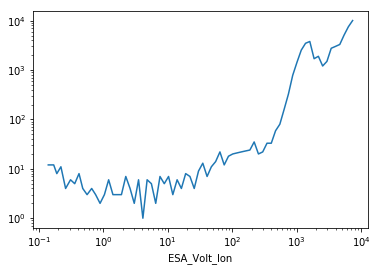

In [15]:
t5a.loc[t5a.index.get_level_values(0)[0]].plot(logy=True, logx=True)

In [16]:
t5a.loc[t5a.index.get_level_values(0)[0]]

ESA_Volt_Ion
0.140015          12.0
0.170044          12.0
0.189941           8.0
0.219971          11.0
0.260010           4.0
0.310059           6.0
0.360107           5.0
0.419922           8.0
0.479980           4.0
0.560059           3.0
0.660156           4.0
0.759766           3.0
0.890137           2.0
1.040039           3.0
1.209961           6.0
1.410156           3.0
1.639648           3.0
1.910156           3.0
2.230469           7.0
2.599609           4.0
3.019531           2.0
3.519531           6.0
4.109375           1.0
4.781250           6.0
5.570312           5.0
6.500000           2.0
7.570312           7.0
8.820312           5.0
10.281250          7.0
11.968750          3.0
                ...   
87.375000         18.0
101.812500        20.0
118.625000        21.0
138.250000        22.0
161.000000        23.0
187.625000        24.0
218.625000        35.0
254.750000        20.0
296.750000        22.0
345.750000        33.0
403.000000        33.0
469.500000        59.

### 36 energies from bottom to top

In [17]:
energies = tb.logspace(0.15, 7350, 36)
energies

array([1.50000000e-01, 2.04219337e-01, 2.78036917e-01, 3.78536765e-01,
       5.15363513e-01, 7.01647966e-01, 9.55267215e-01, 1.30056025e+00,
       1.77066367e+00, 2.41069174e+00, 3.28206579e+00, 4.46840865e+00,
       6.08356968e+00, 8.28255043e+00, 1.12763797e+01, 1.53523652e+01,
       2.09016656e+01, 2.84568286e+01, 3.87428977e+01, 5.27469925e+01,
       7.18130389e+01, 9.77707411e+01, 1.33111173e+02, 1.81225836e+02,
       2.46732133e+02, 3.35916484e+02, 4.57337611e+02, 6.22647890e+02,
       8.47711594e+02, 1.15412733e+03, 1.57130079e+03, 2.13926669e+03,
       2.91253084e+03, 3.96530077e+03, 5.39860729e+03, 7.35000000e+03])

In [18]:
d1 = t5a.loc[t5a.index.get_level_values(0)[0]]

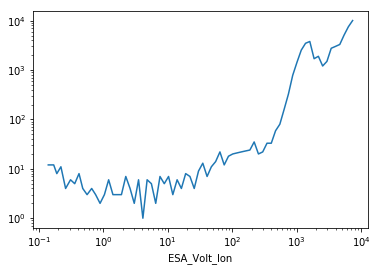

In [19]:
d1.plot(logy=True, logx=True)

In [20]:
d1.head()

ESA_Volt_Ion
0.140015    12.0
0.170044    12.0
0.189941     8.0
0.219971    11.0
0.260010     4.0
Name: Ion_Cntr_H, dtype: float16

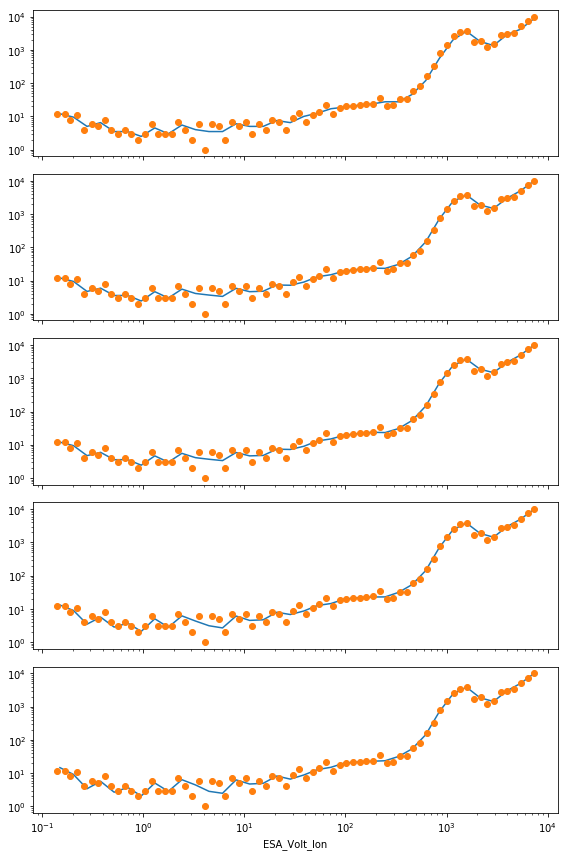

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(8,12), sharex=True)
d2linear = d1.reindex(d1.index.union(energies)).interpolate(method='linear')
d2linear.loc[energies].plot(logx=True, logy=True, ax=ax[0])

d2index = d1.reindex(d1.index.union(energies)).interpolate(method='index')
d2index.loc[energies].plot(logx=True, logy=True, ax=ax[1])

d2slinear = d1.reindex(d1.index.union(energies)).interpolate(method='slinear')
d2slinear.loc[energies].plot(logx=True, logy=True, ax=ax[2])

d2squadratic = d1.reindex(d1.index.union(energies)).interpolate(method='quadratic')
d2squadratic.loc[energies].plot(logx=True, logy=True, ax=ax[3])

d2cubic = d1.reindex(d1.index.union(energies)).interpolate(method='cubic')
d2cubic.loc[energies].plot(logx=True, logy=True, ax=ax[4])



d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[0])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[1])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[2])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[3])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[4])




plt.tight_layout()

### make a numpy array of the data

In [22]:
times = np.unique(t5a.index.get_level_values(0))
print(len(times))

289


In [23]:
FPDU = np.zeros((len(times), 36), dtype=float)
for i in tqdm.tqdm(range(len(times))):
    d1 = t5a.loc[times[i]]
    FPDU[i] = d1.reindex(d1.index.union(energies)).interpolate(method='cubic', check_finite=True, ext=1).loc[energies]


100%|██████████| 289/289 [00:00<00:00, 296.51it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


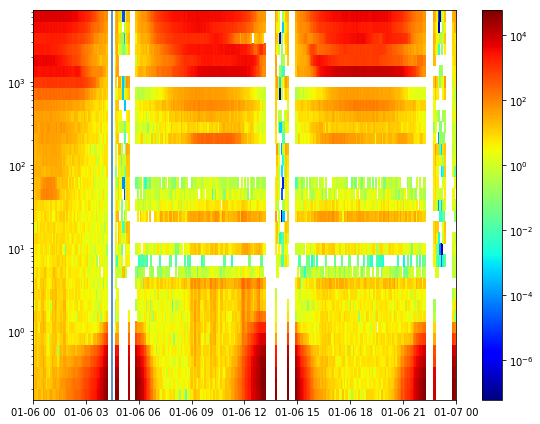

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)

pcm = ax.pcolormesh(times, energies, FPDU.T, norm=LogNorm(), cmap='jet')
ax.set_yscale('log')
ax.set_ylim((energies.min(), energies.max()))
plt.colorbar(pcm)
plt.tight_layout()
plt.axvline(times[54])

In [25]:
FPDU = np.zeros((len(times), 36), dtype=float)
for i in tqdm.tqdm(range(len(times))):
    d1 = t5a.loc[times[i]]
    d1 = d1.loc[np.isfinite(d1)]
    FPDU[i] = d1.reindex(d1.index.union(energies)).interpolate(method='cubic', 
                                                               check_finite=True, 
                                                               ext=1).loc[energies]


100%|██████████| 289/289 [00:00<00:00, 320.08it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


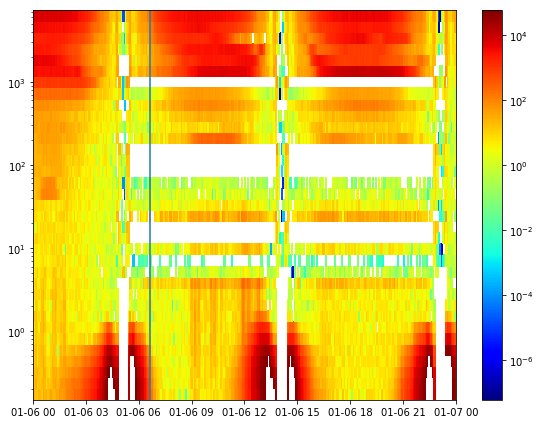

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)

pcm = ax.pcolormesh(times, energies, FPDU.T, norm=LogNorm(), cmap='jet')
ax.set_yscale('log')
ax.set_ylim((energies.min(), energies.max()))
plt.colorbar(pcm)
plt.tight_layout()
plt.axvline(times[80])

In [27]:
FPDU[80]

array([ 2.87750000e+02,  1.88125000e+02,  1.32750000e+02,  4.46562500e+01,
        2.19531250e+01,  1.79882812e+00,  2.41210938e+00,  3.65820312e+00,
        7.56225586e-02,  3.79296875e+00,  4.45703125e+00,  3.97949219e-01,
        3.61328125e-02,  2.05859375e+00, -3.09179688e+00, -2.06054688e+00,
       -3.91601562e-01,  3.93310547e-01,  6.01562500e-01, -2.20184326e-02,
       -2.76611328e-01, -3.19335938e+00, -8.04687500e+00,  2.67382812e+00,
        3.61914062e+00,  5.09375000e+00,  8.76562500e+00,  1.22753906e+00,
       -1.05156250e+01,  4.37187500e+01,  2.23750000e+01,  3.60937500e+01,
        7.39375000e+01,  1.17000000e+02,  2.53250000e+02,  6.26500000e+02])

ESA_Volt_Ion
0.140015       262.00
0.170044       258.00
0.189941       201.50
0.219971       185.75
0.260010       143.00
0.310059       120.00
0.360107        57.75
0.419922        39.00
0.479980        32.00
0.560059         9.00
0.660156         1.00
0.759766         3.00
0.890137         2.00
1.040039         3.00
1.209961         1.00
1.410156         7.00
1.639648         1.00
1.910156         2.00
2.230469         5.00
2.599609         2.00
3.019531         3.00
3.519531         1.00
3.550781         0.00
3.960938         0.00
4.109375         2.00
4.410156         0.00
4.781250         3.00
4.910156         0.00
5.460938         0.00
5.570312         0.00
                ...  
1175.000000     16.00
1182.000000      0.00
1317.000000      0.00
1369.000000     20.00
1466.000000      0.00
1595.000000     19.00
1633.000000      0.00
1818.000000      0.00
1859.000000     14.00
2025.000000      0.00
2166.000000     39.00
2254.000000      0.00
2510.000000      0.00
2524.000000     39.

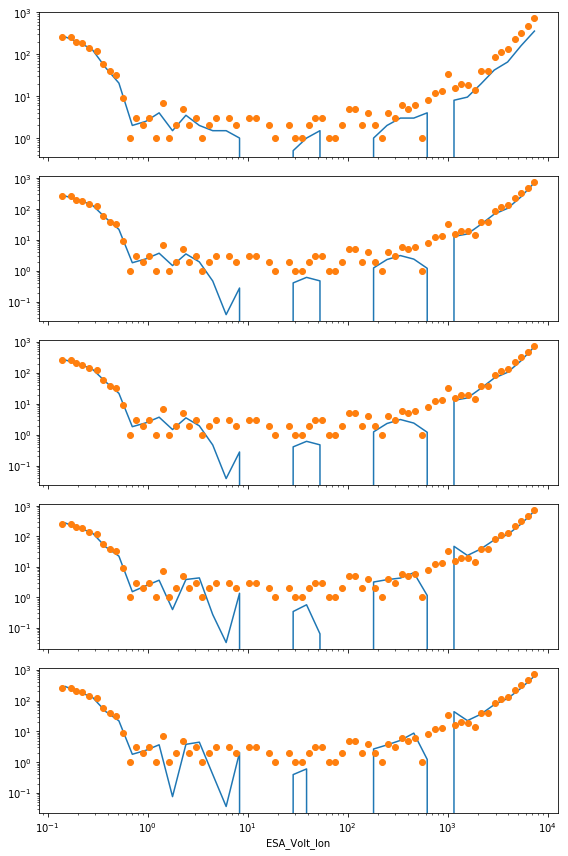

In [28]:
d1 = t5a.loc[times[80]]
d1 = d1.loc[np.isfinite(d1)]
print(d1)

fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(8,12), sharex=True)
d2linear = d1.reindex(d1.index.union(energies)).interpolate(method='linear')
d2linear.loc[energies].plot(logx=True, logy=True, ax=ax[0])

d2index = d1.reindex(d1.index.union(energies)).interpolate(method='index')
d2index.loc[energies].plot(logx=True, logy=True, ax=ax[1])

d2slinear = d1.reindex(d1.index.union(energies)).interpolate(method='slinear')
d2slinear.loc[energies].plot(logx=True, logy=True, ax=ax[2])

d2squadratic = d1.reindex(d1.index.union(energies)).interpolate(method='quadratic')
d2squadratic.loc[energies].plot(logx=True, logy=True, ax=ax[3])

d2cubic = d1.reindex(d1.index.union(energies)).interpolate(method='cubic')
d2cubic.loc[energies].plot(logx=True, logy=True, ax=ax[4])



d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[0])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[1])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[2])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[3])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[4])




plt.tight_layout()

100%|██████████| 289/289 [00:01<00:00, 264.30it/s]
/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


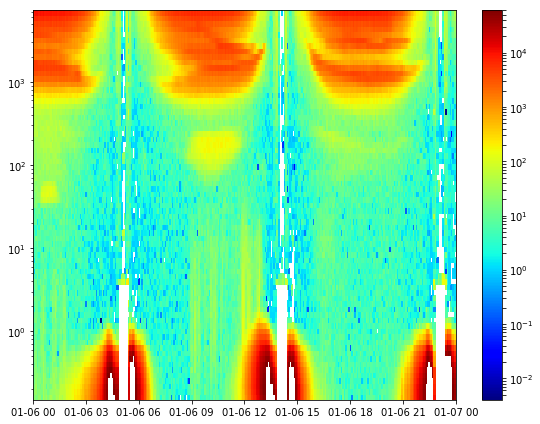

In [53]:
FPDU = np.zeros((len(times), len(energies)), dtype=float)
for i in tqdm.tqdm(range(len(times))):
    d1 = t5a.loc[times[i]]
    d1 = d1.loc[np.isfinite(d1)]
    d1 = d1.loc[d1 > 0]
    FPDU[i] = d1.reindex(d1.index.union(energies)).interpolate(method='cubic', 
                                                               check_finite=True, 
                                                               ext=1, limit=2).loc[energies]
    
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)

pcm = ax.pcolormesh(times, energies, FPDU.T, norm=LogNorm(), cmap='jet')
ax.set_yscale('log')
ax.set_ylim((energies.min(), energies.max()))
plt.colorbar(pcm)
plt.tight_layout()
# plt.axvline(times[63])

100%|██████████| 289/289 [00:00<00:00, 298.23it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


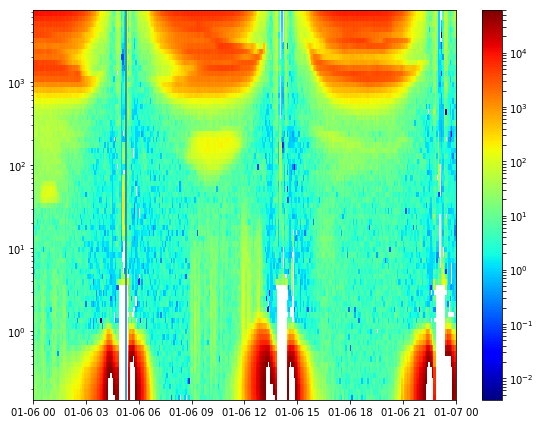

In [37]:
energies = tb.logspace(0.15, 7350, 72)

FPDU = np.zeros((len(times), len(energies)), dtype=float)
for i in tqdm.tqdm(range(len(times))):
    d1 = t5a.loc[times[i]]
    d1 = d1.loc[np.isfinite(d1)]
    d1 = d1.loc[d1 > 0]
    FPDU[i] = d1.reindex(d1.index.union(energies)).interpolate(method='cubic', 
                                                               check_finite=True, 
                                                               ext=1).loc[energies]
    
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)

pcm = ax.pcolormesh(times, energies, FPDU.T, norm=LogNorm(), cmap='jet')
ax.set_yscale('log')
ax.set_ylim((energies.min(), energies.max()))
plt.colorbar(pcm)
plt.tight_layout()
plt.axvline(times[63])

100%|██████████| 289/289 [00:01<00:00, 256.64it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


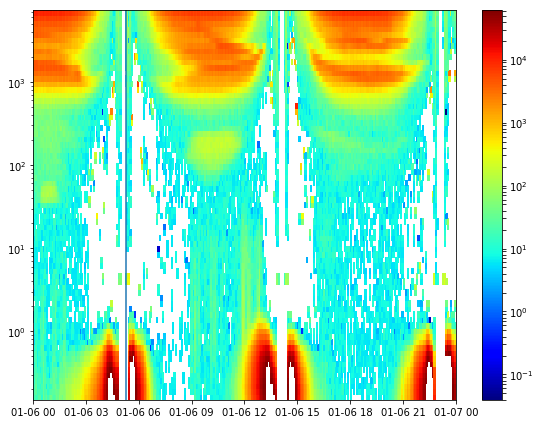

In [44]:
energies = tb.logspace(0.15, 7350, 72)

FPDU = np.zeros((len(times), len(energies)), dtype=float)
for i in tqdm.tqdm(range(len(times))):
    d1 = t5a.loc[times[i]]
    d1 = d1.loc[np.isfinite(d1)]
    d1 = d1.loc[d1 > 0]
    d1 = d1.loc[d1 > 5]
    try:
        FPDU[i] = d1.reindex(d1.index.union(energies)).interpolate(method='cubic', 
                                                                   check_finite=True, 
                                                                   ext=1, 
                                                                  limit=2).loc[energies]
    except ValueError:
        pass
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)

pcm = ax.pcolormesh(times, energies, FPDU.T, norm=LogNorm(), cmap='jet')
ax.set_yscale('log')
ax.set_ylim((energies.min(), energies.max()))
plt.colorbar(pcm)
plt.tight_layout()
plt.axvline(times[63])

100%|██████████| 289/289 [00:01<00:00, 272.18it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


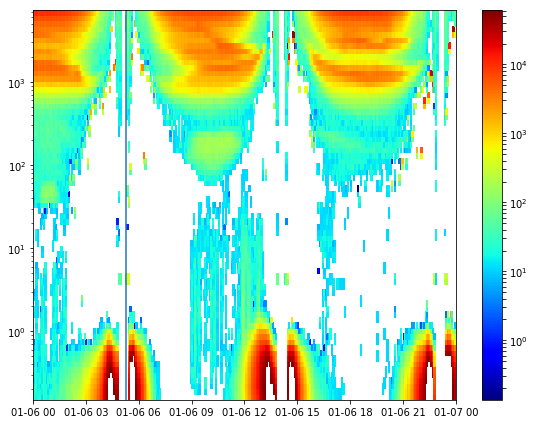

In [51]:
energies = tb.logspace(0.15, 7350, 72)

FPDU = np.zeros((len(times), len(energies)), dtype=float)
for i in tqdm.tqdm(range(len(times))):
    d1 = t5a.loc[times[i]]
    d1 = d1.loc[np.isfinite(d1)]
    d1 = d1.loc[d1 > 0]
    d1 = d1.loc[d1 > 10]
    try:
        FPDU[i] = d1.reindex(d1.index.union(energies)).interpolate(method='cubic', 
                                                                   check_finite=True, 
                                                                   ext=1, 
                                                                  limit=2).loc[energies]
    except ValueError:
        pass
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)

pcm = ax.pcolormesh(times, energies, FPDU.T, norm=LogNorm(), cmap='jet')
ax.set_yscale('log')
ax.set_ylim((energies.min(), energies.max()))
plt.colorbar(pcm)
plt.tight_layout()
plt.axvline(times[63])

100%|██████████| 289/289 [00:01<00:00, 263.47it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


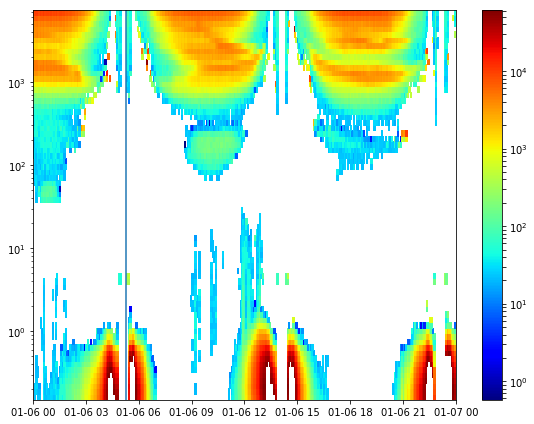

In [46]:
energies = tb.logspace(0.15, 7350, 72)

FPDU = np.zeros((len(times), len(energies)), dtype=float)
for i in tqdm.tqdm(range(len(times))):
    d1 = t5a.loc[times[i]]
    d1 = d1.loc[np.isfinite(d1)]
    d1 = d1.loc[d1 > 0]
    d1 = d1.loc[d1 > 20]
    try:
        FPDU[i] = d1.reindex(d1.index.union(energies)).interpolate(method='cubic', 
                                                                   check_finite=True, 
                                                                   ext=1, 
                                                                  limit=2).loc[energies]
    except ValueError:
        pass
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)

pcm = ax.pcolormesh(times, energies, FPDU.T, norm=LogNorm(), cmap='jet')
ax.set_yscale('log')
ax.set_ylim((energies.min(), energies.max()))
plt.colorbar(pcm)
plt.tight_layout()
plt.axvline(times[63])

100%|██████████| 289/289 [00:01<00:00, 264.65it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


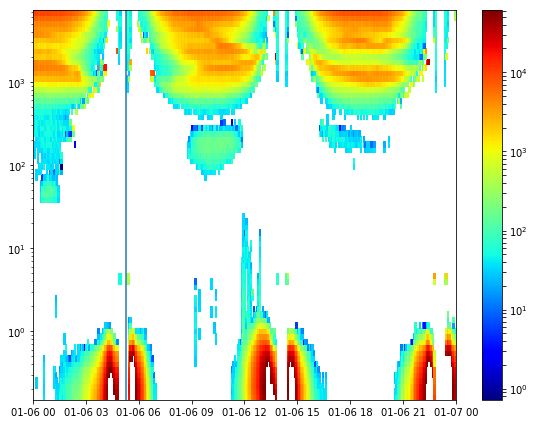

In [47]:
energies = tb.logspace(0.15, 7350, 72)

FPDU = np.zeros((len(times), len(energies)), dtype=float)
for i in tqdm.tqdm(range(len(times))):
    d1 = t5a.loc[times[i]]
    d1 = d1.loc[np.isfinite(d1)]
    d1 = d1.loc[d1 > 0]
    d1 = d1.loc[d1 > 30]
    try:
        FPDU[i] = d1.reindex(d1.index.union(energies)).interpolate(method='cubic', 
                                                                   check_finite=True, 
                                                                   ext=1, 
                                                                  limit=2).loc[energies]
    except ValueError:
        pass
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)

pcm = ax.pcolormesh(times, energies, FPDU.T, norm=LogNorm(), cmap='jet')
ax.set_yscale('log')
ax.set_ylim((energies.min(), energies.max()))
plt.colorbar(pcm)
plt.tight_layout()
plt.axvline(times[63])

In [31]:
FPDU[54]

array([           nan,            nan,            nan,            nan,
       5.18720000e+04, 4.02560000e+04, 2.59680000e+04, 1.62720000e+04,
       1.15760000e+04, 4.54000000e+03, 6.51000000e+02, 2.87500000e+02,
       8.56250000e+01, 8.18750000e+00, 2.23632812e+00, 2.36328125e+00,
       1.59863281e+00, 9.15039062e-01, 1.02734375e+00, 9.90722656e-01,
       1.00585938e+00, 1.00976562e+00, 9.97070312e-01, 9.88769531e-01,
       9.87792969e-01, 9.93652344e-01, 1.00097656e+00, 1.00488281e+00,
       1.00292969e+00, 9.99511719e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99511719e-01,
       1.00000000e+00, 9.99023438e-01, 1.00390625e+00, 9.82421875e-01,
       1.08203125e+00, 2.08203125e+00, 1.94140625e+00, 1.40722656e+00,
       9.68261719e-01, 1.04882812e+00, 2.16992188e+00, 4.18359375e+00,
       4.92968750e+00, 2.82226562e+00, 3.29296875e+00, 6.91796875e+00,
      

In [32]:
d1 = t5a.loc[times[54]]
w = ~np.isfinite(d1)
d1.loc[w] = 0
d1.reindex(d1.index.union(energies)).interpolate(method='cubic', check_finite=True, ext=1, w=~w).loc[energies]


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.150000       -1439.000000
0.174643         438.500000
0.203334       -3168.000000
0.236738       21216.000000
0.275631       60704.000000
0.320913       38208.000000
0.373634       26704.000000
0.435016       16064.000000
0.506482       11672.000000
0.589689        4508.000000
0.686566         659.500000
0.799358         283.750000
0.930680          86.687500
1.083576           7.933594
1.261591           1.834961
1.468851          -0.370605
1.710160           0.326660
1.991113           1.093750
2.318222           0.960449
2.699070           1.055664
3.142485           0.751953
3.658747           0.104492
4.259822           0.974609
4.959645          -0.164795
5.774437           0.016266
6.723087           0.175171
7.827586           0.967773
9.113537          -0.184692
10.610749          0.201660
12.353930          1.086914
                   ...     
89.242853          1.017578
103.904067         0.979004
120.973890         1.077148
140.848020         2.111328
163.987161         1

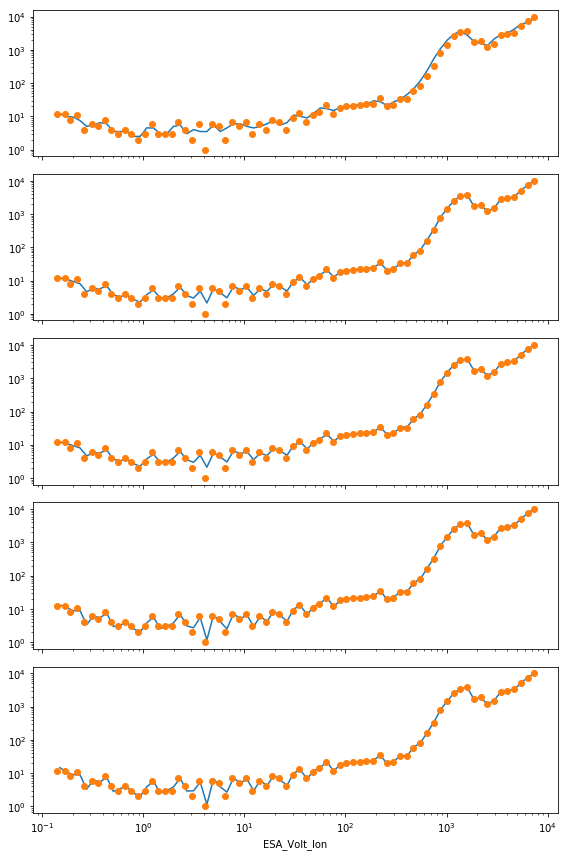

In [38]:
d1 = t5a.loc[times[0]]


fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(8,12), sharex=True)
d2linear = d1.reindex(d1.index.union(energies)).interpolate(method='linear')
d2linear.loc[energies].plot(logx=True, logy=True, ax=ax[0])

d2index = d1.reindex(d1.index.union(energies)).interpolate(method='index')
d2index.loc[energies].plot(logx=True, logy=True, ax=ax[1])

d2slinear = d1.reindex(d1.index.union(energies)).interpolate(method='slinear')
d2slinear.loc[energies].plot(logx=True, logy=True, ax=ax[2])

d2squadratic = d1.reindex(d1.index.union(energies)).interpolate(method='quadratic')
d2squadratic.loc[energies].plot(logx=True, logy=True, ax=ax[3])

d2cubic = d1.reindex(d1.index.union(energies)).interpolate(method='cubic')
d2cubic.loc[energies].plot(logx=True, logy=True, ax=ax[4])



d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[0])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[1])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[2])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[3])
d1.plot(logy=True, logx=True, ls='none', marker='o', ax=ax[4])




plt.tight_layout()

In [33]:
d2.plot(logx=True, logy=True)

NameError: name 'd2' is not defined

In [ ]:
t5.index.get_level_values(1)

In [ ]:
t5.xs(0.1400146484375, level='ESA_Volt_Ion', drop_level=True).plot(logy=True,)
t5.xs(7360.0, level='ESA_Volt_Ion', drop_level=True).plot(logy=True,)


In [ ]:
t5.xs('2014-01-06 00:00:00', level=1, drop_level=True).plot(logy=True, logx=True, label='00:00:00')
t5.xs('2014-01-06 00:10:00', level=1, drop_level=True).plot(logy=True, logx=True, label='00:10:00')
t5.xs('2014-01-06 00:20:00', level=1, drop_level=True).plot(logy=True, logx=True, label='00:20:00')


plt.ylabel('Counts/5min')
# plt.xlabel('Energy')
t5.xs('2014-01-06 00:00:00', level=1, drop_level=True).head()
plt.legend()

In [ ]:
for t in t5.index.get_level_values(1)[0:10]:
    t5.xs(t, level=1, drop_level=True).plot(logy=True, logx=True)


In [ ]:
pd.pivot(t5.index.get_level_values(1), t5.index.get_level_values(0), t5)

In [ ]:
a = []
for t in t5.index.get_level_values(1):
    a.append(t5.loc[t])